<a id='toc'></a>

## Workflow

1. [Prep Your Repo](#prep-your-repo)
1. [Import](#import)
1. [Acquire Data](#acquire-data)
1. [Clean, Prep & Split Data](#clean-prep-and-split-data)
1. [Explore Data](#explore-data)
    - [Hypothesis Testing](#hypothesis-testing)
1. [Evaluate Data](#evaluate-data)
1. [Modeling](#modeling)
    - [Identify Baseline](#identify-baseline)
    - [Train / Validate](#train-validate)
    - [Test](#test)

<a id='top'></a>

 [Jump to the bottom of Repo](#bottom)

<a id='navigation'></a>

<button class="button-save large">[Scenario](#scenario)</button>
<button class="button-save large">[Project Planning](#project-planning)</button>
<button class="button-save large">[Key Findings](#key-findings)</button>
<button class="button-save large">[Tested Hypotheses](#tested-hypotheses)</button>
<button class="button-save large">[Take Aways](#take-aways)</button>
<button class="button-save large">[Data Dictionary](#data-dictionary)</button>
<button class="button-save large">[Workflow](#workflow)</button>

<div class="alert alert-block alert-info"><a name="scenario"></a><h1><i class="fas fa-home"></i> Scenario</h1></div>
Selling homes in our new normal has just gotten easier with Zillow Offers®. Now home owners can hand over the burden of selling their property, by selling directly to us based on our state of the art Zestimate score.

The accuracy and integrity of our Zestimate score is of high importance. As a junior data scientists on the Zillow data science team, we are tasked with uncovering what drivers most affect the validity of the Zestimate score. This is measured by our target variable: `logerror`, which is the difference between Zillow's estimated Zestimate and actual sale price. 
>`logerror` = log (Zestimate) − log (ActualSalePrice)

### Project Goal: 
The goal for this project is to create a model that will accurately predict the Zestimate’s `logerror`. By doing so, we will uncover what features available on the Zillow Dataset are driving the amount of error.


___
# <a name="prep-your-repo"></a>1. Prep Your Repo

1. Create new repo and name it: 'clustering_project'
    - clone
    
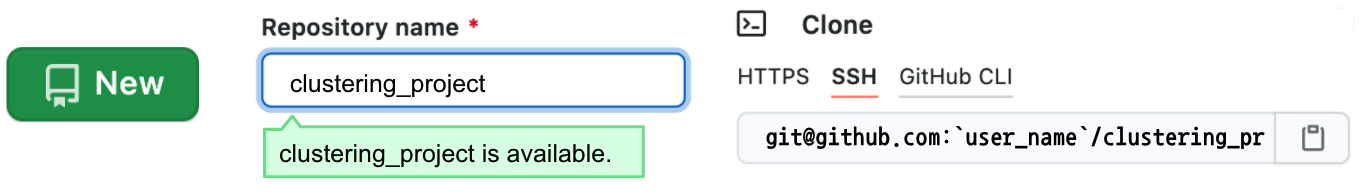


2. Create .gitignore that includes env.py
    - push
3. Create env.py file that stores your MySQL login credentials to obtain `zillow` data.
    - save
    - **confirm it is ignored** (git status)
4. Create README.md file to begin notating steps taken so far.
    - save
    - push
5. Create a Jupyter Lab environment to continue working in.
6. Create Jupyter Notebook to begin data pipeline: `zillow`

___
# <a name="import"></a>2. Import 
Import all necessary libraries and functions. 

In [1]:
# Imports needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy import stats

#functions
import wrangle



warnings.filterwarnings("ignore")

#evaluate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from statsmodels.formula.api import ols
import sklearn.preprocessing

#feature engineering
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

 [Jump to Table of Contents](#toc)

___
# <a name="acquire-data"></a>3. Acquire Data
#### Read `zillow` data from MySQL using the `zillow17()` function in [`wrangle.py`](wrangle.py)

<div class="alert alert-block alert-success">
<b>Acquire Summary:</b> 
<br>- The get_connection() function from wrangle module acquires zillow dataset from Codeup database using Sequel Pro.
<br>- The zillow17() function creates a query that joins the 2017 properties and predictions data and filters data for single unit/single family homes.
<br>- The original, unprepared data set has 77574 rows and 68 columns.
</div>

In [3]:
# Acquire the data from SQL

df = wrangle.zillow17()

#### Initial Exploring:
At this stage, we'd like to get introduced to the data and learn about it's size, attributes, and components.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [5]:
df.shape

(77574, 68)

YIKES! We have a lot of cleaning to do! Lucky for you, we like you, and have cleaned up while you were daydreaming of code....

We addressed:
- single family house holds

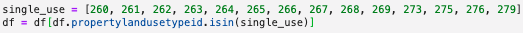

- made sure to drop any columns that had 40%+ nulls, and rows with 30%+ nulls



- created a county list using the fips code
- renamed columns
- filled nulls
- addressed outliers:

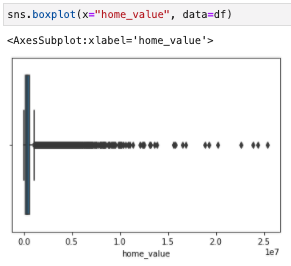

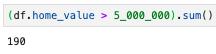

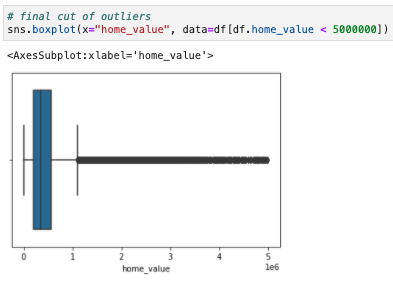

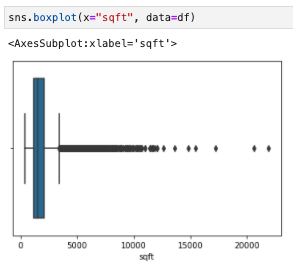  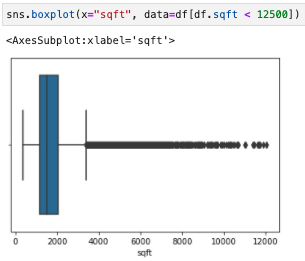

- and even created a few new features

 [Jump to Table of Contents](#toc)

___
# <a name="clean-prep-and-split-data"></a>4. Clean, Prep and Split Data
Using four functions tied to each other in `wrangle.py` file:
- [`clean_zillow()`](wrangle.py)
- [`zillow17()`](wrangle.py)
- [`split_zillow`](wrangle.py)
- [`wrangle_zillow`](wrangle.py)

<div class="alert alert-block alert-success">
<b>Prepare Summary:</b> 
<br>-  <b>Dropped: </b> <br>
- 45 columns and 4323 rows</b> 
<br>- <b>Why drop ?! </b> 
<br>We dropped columns that had > 60% of nulls and dropped rows that had 70% of nulls because we could not gather the missing information from other variables or impute the missing values without high skew.  We also dropped columns that contained redundant information and dropped columns that contained information we would not be using in our models.
<br>- <b>Outliers: </b> <br>
- We handled outliers in taxvaluedollarcnt by dropping values > $5 million
<br>- We handled outliers in calculatedfinishedsquarefeet by dropping values < 500 sqft and > 12500 sqft
<br>- <b>Remaining missing values:</b> <br>
- lotsizesquarefeet missing values were filled with median
<br>- buildingqualitytypeid missing values were filled with median
<br>- remaining missing values were dropped
<br>- <b>Renamed columns: </b> <br>
- 9 columns renamed to accurately represent the data they contain.
<br>- Ex). calculatedfinishedsquarefeet to sqft 
<br>- <b>New features: </b> <br>
- home_age, county, logerror_quartiles
<br>-<b>Split:</b>
<br>
<br>We dropped columns that had > 40% of nulls and dropped rows that had 30% of nulls because we could not gather the missing information from other variables or impute the missing values without high skew.  We also dropped columns that contained redundant information and dropped columns that contained information we would not be using in our models.
<br>-   
</div>

In [2]:
# Dropping unnecessary/redundant columns, dropping nulls/NaNs, and  limiting outliers 

df, train, validate, test = wrangle.wrangle_zillow()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 10711855 to 162960814
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   bathrooms           71818 non-null  float64 
 1   bedrooms            71818 non-null  int64   
 2   property_quality    71818 non-null  int64   
 3   sqft                71818 non-null  float64 
 4   fips                71818 non-null  int64   
 5   latitude            71818 non-null  float64 
 6   longitude           71818 non-null  float64 
 7   lot_sqft            71818 non-null  float64 
 8   yearbuilt           71818 non-null  int64   
 9   structure_value     71818 non-null  float64 
 10  home_value          71818 non-null  float64 
 11  land_value          71818 non-null  float64 
 12  taxamount           71818 non-null  float64 
 13  logerror            71818 non-null  float64 
 14  county              71818 non-null  object  
 15  home_age            71818

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,71818.0,2.272822e+00,0.916359,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01
bedrooms,71818.0,3.016765e+00,0.990155,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
property_quality,71818.0,6.758431e+00,1.350214,1.000000e+00,6.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01
sqft,71818.0,1.741974e+03,873.320788,5.010000e+02,1.172000e+03,1.517000e+03,2.056000e+03,1.203900e+04
fips,71818.0,6.049319e+03,21.083111,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,71818.0,3.400713e+07,267350.751880,3.333953e+07,3.381053e+07,3.402124e+07,3.417671e+07,3.481877e+07
longitude,71818.0,-1.182004e+08,364289.055844,-1.194753e+08,-1.184182e+08,-1.181685e+08,-1.179179e+08,-1.175723e+08
lot_sqft,71818.0,2.775619e+04,118484.322103,2.360000e+02,5.985000e+03,7.265000e+03,1.061925e+04,6.971010e+06
yearbuilt,71818.0,1.969569e+03,22.904501,1.878000e+03,1.954000e+03,1.971000e+03,1.987000e+03,2.016000e+03
structure_value,71818.0,1.827604e+05,180690.499855,4.400000e+01,8.438700e+04,1.355560e+05,2.157475e+05,3.348387e+06


 [Jump to Table of Contents](#toc)

___
# <a name="explore-data"></a>5. Explore Data
<div class="alert alert-block alert-success">
<b>Explore Summary:</b> 
This is an ideal time to split and scale your data. Since many of our feature have varying units of measurement, scaling will level out the playing field.  
</div>

In [5]:
# Check our train, validate, test

train.shape, validate.shape, test.shape

((40217, 17), (17237, 17), (14364, 17))

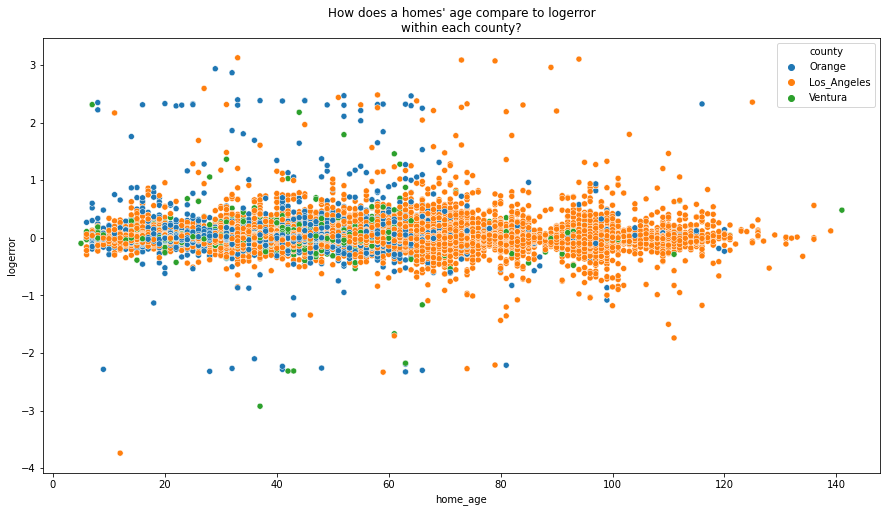

In [6]:
# How does a homes' age compare to logerror by county?

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='home_age', y='logerror',
               data=train, hue='county')
plt.title("How does a homes' age compare to logerror\nwithin each county?")
plt.show()

In [4]:
# Create some more-nuanced features

train['structure_dollar_per_sqft'] = train.structure_value / train.sqft
train['land_dollar_per_sqft'] = train.land_value / train.lot_sqft
train['bed_bath_ratio'] = train.bedrooms / train.bathrooms

In [5]:
# Add features to original dataframe

df['structure_dollar_per_sqft'] = df.structure_value / df.sqft
df['land_dollar_per_sqft'] = df.land_value / df.lot_sqft
df['bed_bath_ratio'] = df.bedrooms / df.bathrooms

In [10]:
df.head(2)

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,yearbuilt,structure_value,home_value,land_value,taxamount,logerror,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
parcelid,,,,,,,,,,,,,,,,,,,,
10711855,2.0,3,8,2107.0,6037,34222559.0,-118617387.0,9158.0,1972,249655.0,624139.0,374484.0,7659.36,-0.007357,Los_Angeles,49,q2,118.488372,40.891461,1.5
10711877,2.0,4,8,1882.0,6037,34220261.0,-118616409.0,9035.0,1972,253000.0,660000.0,407000.0,8123.91,0.021066,Los_Angeles,49,q3,134.431456,45.047039,2.0


In [11]:
# Check out our data with new columns

train.head()

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,yearbuilt,structure_value,home_value,land_value,taxamount,logerror,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
parcelid,,,,,,,,,,,,,,,,,,,,
14412168,2.5,3,7,1426.0,6059,33525042.0,-117692408.0,6300.0,1987,172674.0,692000.0,519326.0,7021.26,0.013504,Orange,34,q3,121.089762,82.432698,1.200000
14613733,2.5,2,7,1305.0,6059,33567801.0,-117719863.0,3267.0,1995,152831.0,405348.0,252517.0,4071.24,0.028000,Orange,26,q3,117.111877,77.293235,0.800000
13001890,3.0,3,8,1786.0,6037,34076007.0,-118055033.0,6828.0,1987,172378.0,541648.0,369270.0,6812.38,-0.014972,Los_Angeles,34,q2,96.516237,54.081722,1.000000
14606294,1.5,2,7,1190.0,6059,33636000.0,-117679000.0,7265.0,1979,63383.0,259017.0,195634.0,2738.40,-0.001737,Orange,42,q2,53.263025,26.928286,1.333333
11624931,2.0,3,8,1812.0,6037,34054781.0,-118400961.0,6100.0,1936,138820.0,469245.0,330425.0,5722.06,0.073019,Los_Angeles,85,q4,76.611479,54.168033,1.500000


In [12]:
# Descriptive stats on the feature

train.structure_dollar_per_sqft.describe()

count    40217.000000
mean        99.652553
std         59.747870
min          0.039833
25%         63.173026
50%         91.990683
75%        124.463519
max       1444.221106
Name: structure_dollar_per_sqft, dtype: float64

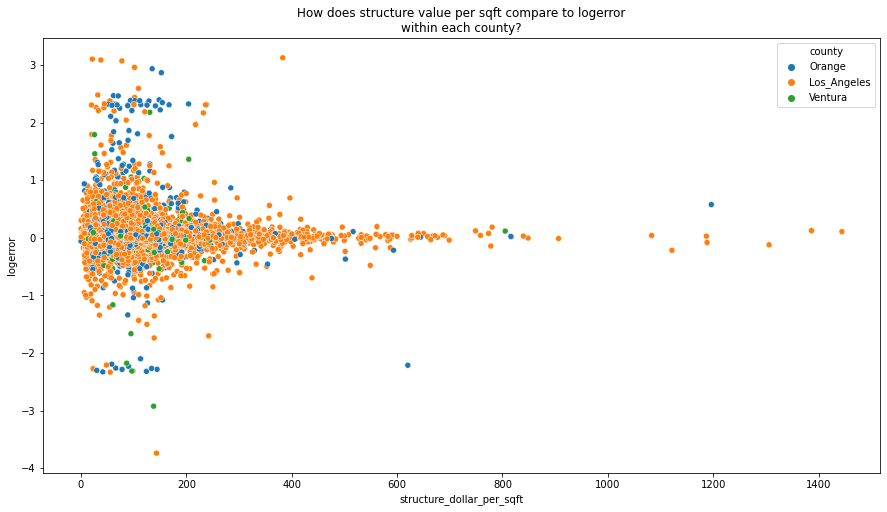

In [15]:
# Scatterplot to visualize how the homes' cost per sqft affects the logerror per county

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='structure_dollar_per_sqft', y='logerror',
               data=train, hue='county')
plt.title("How does structure value per sqft compare to logerror\nwithin each county?")
plt.show()

In [13]:
# Descriptive stats on the feature

train.land_dollar_per_sqft.describe()

count    40217.000000
mean        41.220118
std         60.604258
min          0.003023
25%          6.377221
50%         25.471846
75%         52.003883
max       1526.002353
Name: land_dollar_per_sqft, dtype: float64

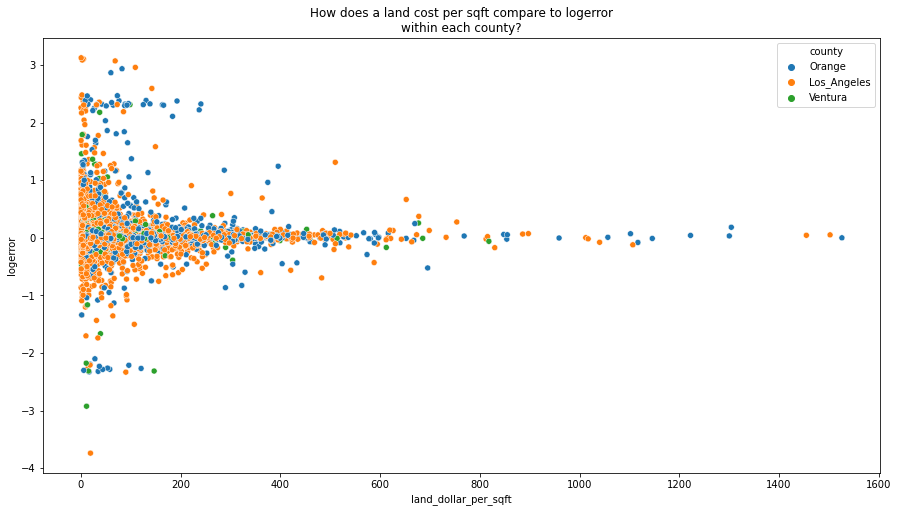

In [17]:
# Scatterplot to visualize how the lots' cost per sqft affects the logerror per county

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='land_dollar_per_sqft', y='logerror',
               data=train, hue='county')
plt.title("How does a land cost per sqft compare to logerror\nwithin each county?")
plt.show()

In [14]:
# Descriptive stats on the feature

train.bed_bath_ratio.describe()

count    40217.000000
mean         1.449140
std          0.561056
min          0.133333
25%          1.000000
50%          1.333333
75%          1.666667
max          5.000000
Name: bed_bath_ratio, dtype: float64

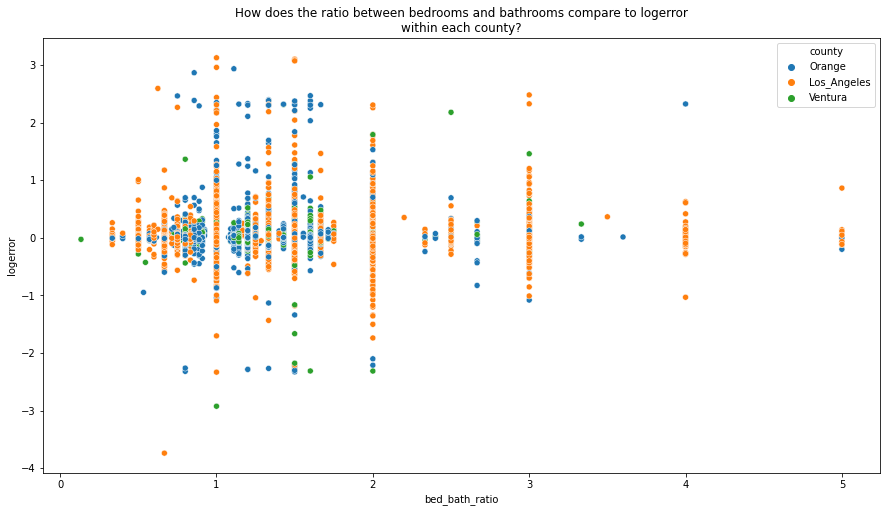

In [19]:
# Scatterplot to visualize how the bed/bath ratio affects the logerror per county

plt.rcParams['figure.figsize'] = (15.0, 8.0)
sns.scatterplot(x='bed_bath_ratio', y='logerror',
               data=train, hue='county')
plt.title("How does the ratio between bedrooms and bathrooms compare to logerror\nwithin each county?")
plt.show()

## Scale the Data

In [20]:
train.head()

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,yearbuilt,structure_value,home_value,land_value,taxamount,logerror,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
parcelid,,,,,,,,,,,,,,,,,,,,
14412168,2.5,3,7,1426.0,6059,33525042.0,-117692408.0,6300.0,1987,172674.0,692000.0,519326.0,7021.26,0.013504,Orange,34,q3,121.089762,82.432698,1.200000
14613733,2.5,2,7,1305.0,6059,33567801.0,-117719863.0,3267.0,1995,152831.0,405348.0,252517.0,4071.24,0.028000,Orange,26,q3,117.111877,77.293235,0.800000
13001890,3.0,3,8,1786.0,6037,34076007.0,-118055033.0,6828.0,1987,172378.0,541648.0,369270.0,6812.38,-0.014972,Los_Angeles,34,q2,96.516237,54.081722,1.000000
14606294,1.5,2,7,1190.0,6059,33636000.0,-117679000.0,7265.0,1979,63383.0,259017.0,195634.0,2738.40,-0.001737,Orange,42,q2,53.263025,26.928286,1.333333
11624931,2.0,3,8,1812.0,6037,34054781.0,-118400961.0,6100.0,1936,138820.0,469245.0,330425.0,5722.06,0.073019,Los_Angeles,85,q4,76.611479,54.168033,1.500000


In [6]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test_split(df, "logerror", 6543)

In [7]:
X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((40217, 19), (40217,), (17237, 19), (17237,), (14364, 19), (14364,))

Separate out numerical/object variables

In [8]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.wrangle_zillow(df, 'logerror', 123)object_cols = wrangle.get_object_cols(df)
object_cols

['county', 'logerror_quartiles']

In [24]:
numeric_cols = wrangle.get_numeric_X_cols(train, object_cols)
numeric_cols

['bathrooms',
 'bedrooms',
 'property_quality',
 'sqft',
 'fips',
 'latitude',
 'longitude',
 'lot_sqft',
 'yearbuilt',
 'structure_value',
 'home_value',
 'land_value',
 'taxamount',
 'logerror',
 'home_age',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'bed_bath_ratio']

In [10]:
# remove target: `logerror` from numerical list
numeric_cols = ['bathrooms',
 'bedrooms',
 'property_quality',
 'sqft',
 'fips',
 'latitude',
 'longitude',
 'lot_sqft',
 'yearbuilt',
 'structure_value',
 'home_value',
 'land_value',
 'taxamount',
 'home_age']

Scale data to explore freely

In [11]:
def Standard_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs
    """
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train[numeric_cols])
    
    X_train_scaled = pd.DataFrame(scaler.transform(X_train[numeric_cols]), index = X_train.index, columns = numeric_cols)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate[numeric_cols]), index = X_validate.index, columns = numeric_cols)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_cols]), index = X_test.index, columns = numeric_cols)
                                 
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [12]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Standard_Scaler(X_train, X_validate, X_test)

### We'd like to explore the clustering of a few features, but not sure where to start.

The following loop helped us save time with hitting our initial hypotheses goals.

In [13]:
#list of numeric_cols with our hypothesis feature filtered out
cols = ['bathrooms',
 'bedrooms',
 'property_quality',
 'sqft',
 'fips',
 'latitude',
 'longitude',
 'lot_sqft',
 'yearbuilt',
 'structure_value',
 'home_value',
 'land_value',
 'taxamount']

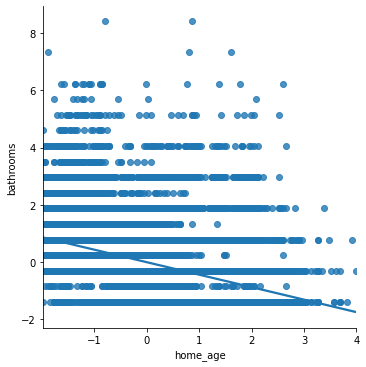

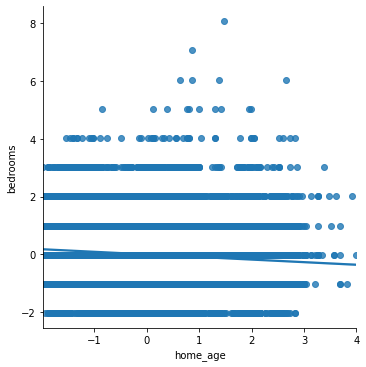

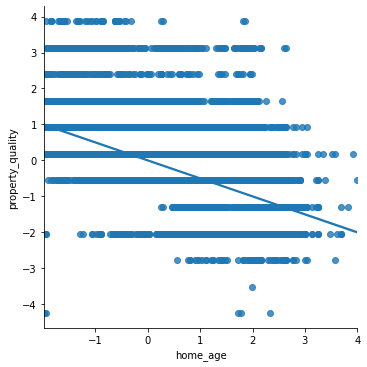

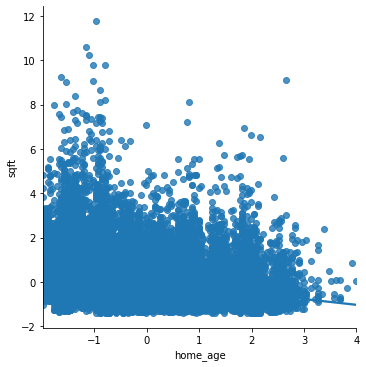

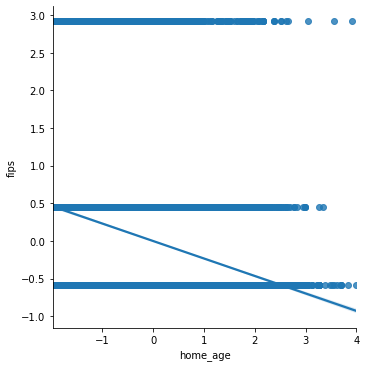

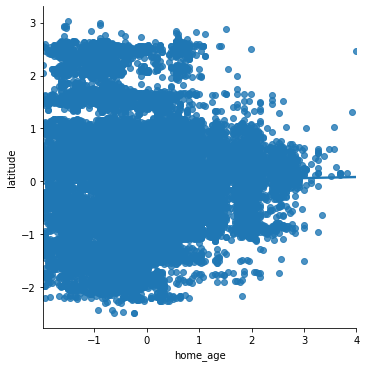

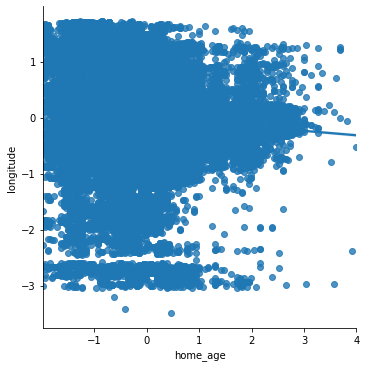

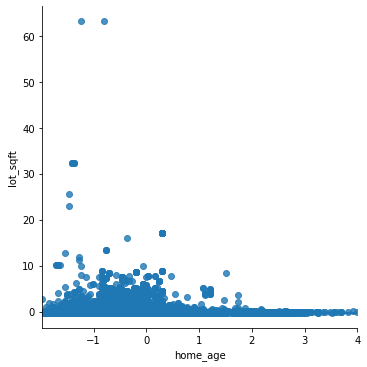

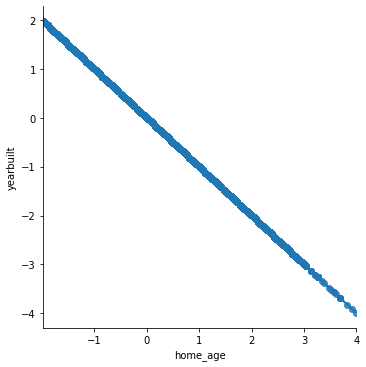

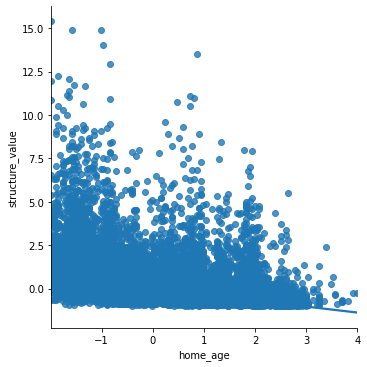

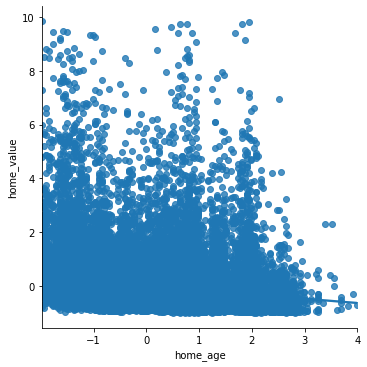

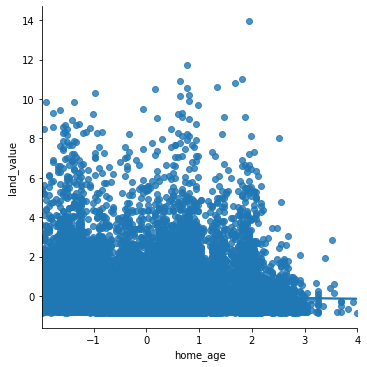

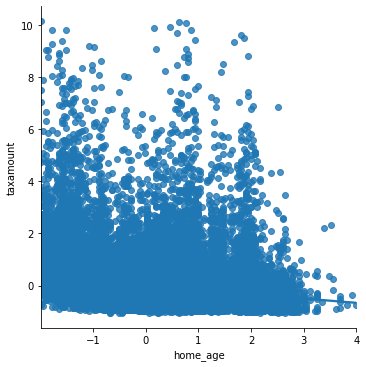

In [14]:
# this loop will create lmplots of `home_age` and everything in the list:

for col in cols:
    g = sns.lmplot(x='home_age', y=col, data=X_train_scaled)

We repeated this process with:
- `home_value`
- `lot_sqft`

And decided to explore further:
- `home_age` & `sqft`
- `property_quality` & `home_age`

#### `home_age` & `sqft`

In [15]:
X = df[['home_age', 'sqft']]

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

k =2 

kmeans = KMeans(n_clusters= k)
kmeans.fit(X_scaled)
kmeans.inertia_

89344.5072402076

By using the Elbow method, we can determine a better suited k value by where the exponentially decaying graph begins to curve the most (or at it's 'elbow').

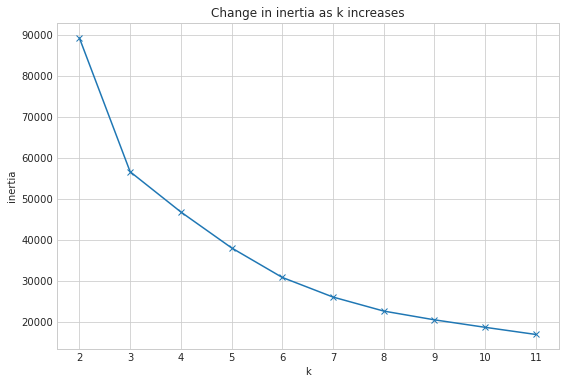

In [16]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [17]:
# define independent variables for k-means
# this is creating a 2col df of the features
X = df[['home_age', 'sqft']]
X.head(2)

,home_age,sqft
parcelid,,
10711855,49,2107.0
10711877,49,1882.0


In [18]:
# Scale the X

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [19]:
#define the thing
kmeans = KMeans(n_clusters=6)

# fit the thing
kmeans.fit(X_scaled)

# Use (predict using) the thing 
kmeans.predict(X_scaled)

array([0, 0, 0, ..., 4, 3, 4], dtype=int32)

In [20]:
# make a new column names cluster in dataframe

df['cluster'] = kmeans.predict(X_scaled)
df.head(2)

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,yearbuilt,structure_value,...,land_value,taxamount,logerror,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cluster
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,2.0,3,8,2107.0,6037,34222559.0,-118617387.0,9158.0,1972,249655.0,...,374484.0,7659.36,-0.007357,Los_Angeles,49,q2,118.488372,40.891461,1.5,0
10711877,2.0,4,8,1882.0,6037,34220261.0,-118616409.0,9035.0,1972,253000.0,...,407000.0,8123.91,0.021066,Los_Angeles,49,q3,134.431456,45.047039,2.0,0


In [21]:
# Cluster Centers aka centroids. The output is scaled!!
kmeans.cluster_centers_

array([[ 0.25241819,  0.81059829],
       [-0.9453625 ,  3.03537554],
       [-0.58066844, -0.55574274],
       [ 0.64282467, -0.48257172],
       [-1.27600555,  0.6009863 ],
       [ 1.93386482, -0.42279581]])

In [22]:
# Make a dataframe 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
centroids_scaled

,home_age,sqft
0,0.252418,0.810598
1,-0.945362,3.035376
2,-0.580668,-0.555743
3,0.642825,-0.482572
4,-1.276006,0.600986
5,1.933865,-0.422796


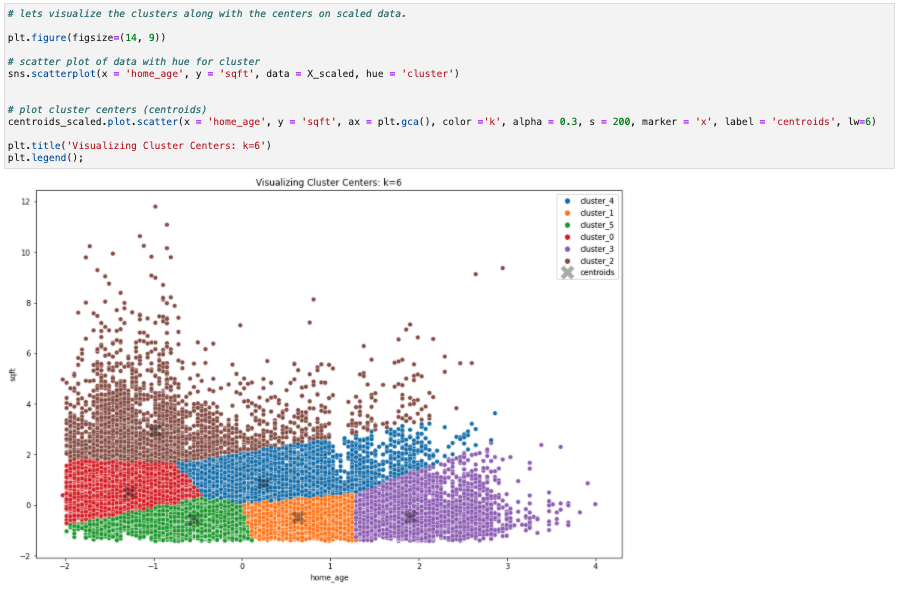

#### `property_quality` & `home_age`

In [23]:
X = df[['property_quality', 'home_age']]

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

k =2 

kmeans = KMeans(n_clusters= k)
kmeans.fit(X_scaled)
kmeans.inertia_

70985.18253639087

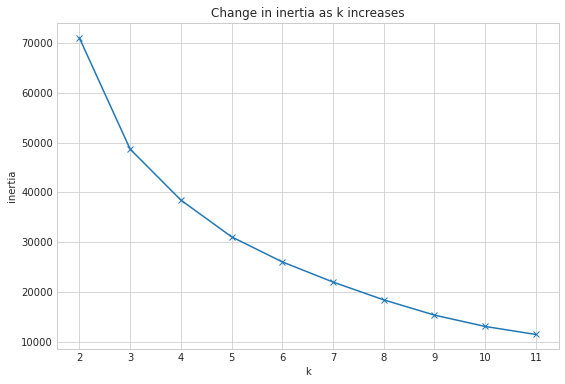

In [24]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [25]:
# define independent variables for k-means
# this is creating a 2col df of the features
X = df[['property_quality', 'home_age']]
X.head(2)

,property_quality,home_age
parcelid,,
10711855,8,49
10711877,8,49


In [26]:
# Scale the X

scaler = sklearn.preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [27]:
#define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X_scaled)

# Use (predict using) the thing 
kmeans.predict(X_scaled)

array([1, 1, 1, ..., 4, 1, 4], dtype=int32)

In [28]:
# make a new column names cluster in dataframe

df['pqha_cluster'] = kmeans.predict(X_scaled)
df.head(2)

,bathrooms,bedrooms,property_quality,sqft,fips,latitude,longitude,lot_sqft,yearbuilt,structure_value,...,taxamount,logerror,county,home_age,logerror_quartiles,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cluster,pqha_cluster
parcelid,,,,,,,,,,,,,,,,,,,,,
10711855,2.0,3,8,2107.0,6037,34222559.0,-118617387.0,9158.0,1972,249655.0,...,7659.36,-0.007357,Los_Angeles,49,q2,118.488372,40.891461,1.5,0,1
10711877,2.0,4,8,1882.0,6037,34220261.0,-118616409.0,9035.0,1972,253000.0,...,8123.91,0.021066,Los_Angeles,49,q3,134.431456,45.047039,2.0,0,1


In [29]:
# Cluster Centers aka centroids. The output is scaled!!
kmeans.cluster_centers_

array([[ 2.21393774, -0.75441651],
       [ 0.3797097 ,  0.0063667 ],
       [-1.94429349,  1.25035872],
       [-0.24867611,  0.98064645],
       [ 0.28561532, -1.09572216]])

In [30]:
# Make a dataframe 
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
centroids_scaled

,property_quality,home_age
0,2.213938,-0.754417
1,0.379710,0.006367
2,-1.944293,1.250359
3,-0.248676,0.980646
4,0.285615,-1.095722


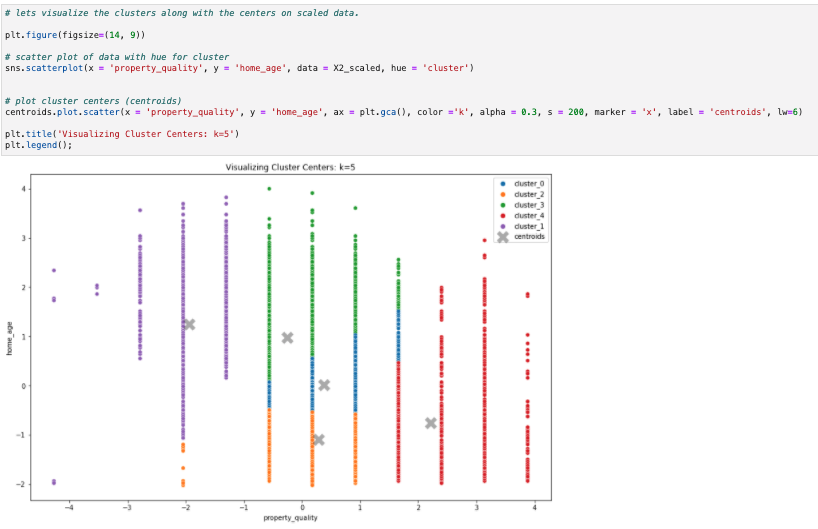

Now, we will turn our clusters into encoded features:

In [31]:
cluster_dummies = pd.get_dummies(df.cluster, prefix='homeagexsqft')

In [33]:
cluster_dummies = cluster_dummies.rename(columns={"homeagexsqft_0": "young_smhome", "homeagexsqft_1": "middleaged_smhome", "homeagexsqft_2": "old_smhome", "homeagexsqft_3": "young_avghome", "homeagexsqft_4": "veteran_avghome", "homeagexsqft_5": "lghome"})

In [34]:
cluster_dummies

,young_smhome,middleaged_smhome,old_smhome,young_avghome,veteran_avghome,lghome
parcelid,,,,,,
10711855,1,0,0,0,0,0
10711877,1,0,0,0,0,0
10711888,1,0,0,0,0,0
10711910,0,0,0,1,0,0
10711923,1,0,0,0,0,0
...,...,...,...,...,...,...
93577187,0,0,1,0,0,0
162960516,0,0,1,0,0,0
162960529,0,0,0,0,1,0


In [35]:
cluster_dummies2 =  pd.get_dummies(df.pqha_cluster, prefix='homeagexquality')

In [39]:
cluster_dummies2 = cluster_dummies2.rename(columns={"homeagexquality_0": "avgqualityavgage", "homeagexquality_1": "poor_quality_old_age", "homeagexquality_2": "avq_quality_young_age", "homeagexquality_3": "avg_quality_old_age", "homeagexquality_4": "bestest"})

In [40]:
cluster_dummies2

,avgqualityavgage,poor_quality_old_age,avq_quality_young_age,avg_quality_old_age,bestest
parcelid,,,,,
10711855,0,1,0,0,0
10711877,0,1,0,0,0
10711888,0,1,0,0,0
10711910,0,1,0,0,0
10711923,0,1,0,0,0
...,...,...,...,...,...
93577187,0,0,0,0,1
162960516,0,0,0,0,1
162960529,0,0,0,0,1


In [41]:
# append dummy df cols to the original df. 
df = pd.concat([df, cluster_dummies, cluster_dummies2], axis=1)

In [42]:
df.head(2).T

parcelid,10711855,10711877
bathrooms,2,2
bedrooms,3,4
property_quality,8,8
sqft,2107,1882
fips,6037,6037
latitude,3.42226e+07,3.42203e+07
longitude,-1.18617e+08,-1.18616e+08
lot_sqft,9158,9035
yearbuilt,1972,1972
structure_value,249655,253000


In [43]:
# drop cluster columns as we have already encoded them
df = df.drop(['cluster', 'pqha_cluster'], axis=1)

In [44]:
df.head(2).T

parcelid,10711855,10711877
bathrooms,2,2
bedrooms,3,4
property_quality,8,8
sqft,2107,1882
fips,6037,6037
latitude,3.42226e+07,3.42203e+07
longitude,-1.18617e+08,-1.18616e+08
lot_sqft,9158,9035
yearbuilt,1972,1972
structure_value,249655,253000


 [Jump to Table of Contents](#toc)

___
# <a name="hypothesis-testing"></a> • Hypothesis Testing

The following function will be used to run our correlation hypothesis tests

In [45]:
def correlation_test(nullh, alth, x, y):
    '''
    correlation_test will take in two arguments and 
    - plot a scatterplot of them
    - test the correlation
    return: the correlation coefficient, p, and if there is a linear relationship.
    '''
    
    splot = plt.scatter(x, y)
    
    null_hypothesis = nullh
    alternative_hypothesis = alth
    
    confidence_level = .95
    a = 1 - confidence_level 
    
    corr, p = stats.pearsonr(x, y)

    if p < a:
        print(f"Reject null statment: {null_hypothesis}")
        print("There is a linear relationship.")
        if 0 < corr < .6:
            print("Although, it is a positive weak one.")
        elif .6 < corr < 1:
            print("That is a stronger positive correlation.")
        elif -.6 < corr < 0:
            print("Although, it is a negative weak one.")
        elif -1 < corr < -.6:
            print("That is a stronger negative correlation.")
        
    else : 
        print("Fail to reject the null hypothesis.")
        
    print(f"""
    Correlation Coefficient: {corr}
    p: {p}
    
    """)
    return splot

TEST: There is a relationship between `home_age` and `logerror`.

In [46]:
#assign your null hypothesis
nullh = "No correlation between home_age and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between home_age and logerror."

#the feature you are testing
x1 = X_train_scaled.home_age

#against your target
y1 = y_train

Fail to reject the null hypothesis.

    Correlation Coefficient: -0.00873058111604275
    p: 0.07997604134928446
    
    


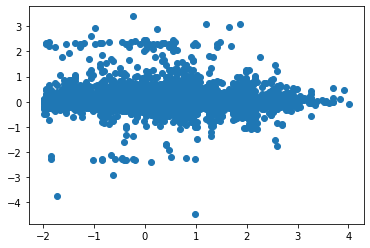

In [47]:
correlation_test(nullh, alth, x1, y1)

TEST: There is a relationship between lotsize and logerror.

In [48]:
#assign your null hypothesis
nullh = "No correlation between lot_sqft and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between lot_sqft and logerror."

#the feature you are testing
x2 = X_train_scaled.lot_sqft

#against your target
y2 = y_train

Reject null statment: No correlation between lot_sqft and logerror.
There is a linear relationship.
Although, it is a positive weak one.

    Correlation Coefficient: 0.014588295096160199
    p: 0.003437626102056948
    
    


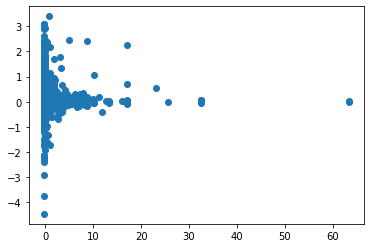

In [49]:
correlation_test(nullh, alth, x2, y2)

TEST: There is a relationship between home_value and logerror.

In [50]:
#assign your null hypothesis
nullh = "No correlation between home_value and logerror."

#and your alternative hypothesis
alth = "There IS a correlation between home_value and logerror."

#the feature you are testing
x3 = X_train_scaled.home_value

#against your target
y3 = y_train

Fail to reject the null hypothesis.

    Correlation Coefficient: 0.0047845368498314516
    p: 0.33731943835407124
    
    


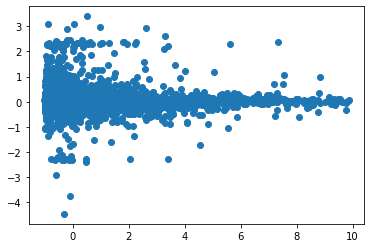

In [51]:
correlation_test(nullh, alth, x3, y3)

 [Jump to Table of Contents](#toc)

___
# <a name="evaluate-data"></a>6. Evaluate Data

In [60]:
#identify your 'objects'/categorical data
object_cols = wrangle.get_object_cols(df)
object_cols

['county', 'logerror_quartiles']

In [62]:
df.columns.to_list()

['bathrooms',
 'bedrooms',
 'property_quality',
 'sqft',
 'fips',
 'latitude',
 'longitude',
 'lot_sqft',
 'yearbuilt',
 'structure_value',
 'home_value',
 'land_value',
 'taxamount',
 'logerror',
 'county',
 'home_age',
 'logerror_quartiles',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'bed_bath_ratio',
 'young_smhome',
 'middleaged_smhome',
 'old_smhome',
 'young_avghome',
 'veteran_avghome',
 'lghome',
 'avgqualityavgage',
 'poor_quality_old_age',
 'avq_quality_young_age',
 'avg_quality_old_age',
 'bestest']

In [63]:
numeric_cols = ['bathrooms',
 'bedrooms',
 'property_quality',
 'sqft',
 'fips',
 'latitude',
 'longitude',
 'lot_sqft',
 'yearbuilt',
 'structure_value',
 'home_value',
 'land_value',
 'taxamount',
 'home_age',
 'structure_dollar_per_sqft',
 'land_dollar_per_sqft',
 'bed_bath_ratio',
 'young_smhome',
 'middleaged_smhome',
 'old_smhome',
 'young_avghome',
 'veteran_avghome',
 'lghome',
 'avgqualityavgage',
 'poor_quality_old_age',
 'avq_quality_young_age',
 'avg_quality_old_age',
 'bestest']

RE-split & -scale your data with your new encoded features.

In [65]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test_split(df, "logerror", 6543)

In [66]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Standard_Scaler(X_train, X_validate, X_test)

In [68]:
X_train_scaled.head(2).T

parcelid,12772448,11511563
bathrooms,-0.296901,-0.296901
bedrooms,-0.015589,-1.026771
property_quality,-0.558369,0.180240
sqft,-0.373833,-0.390981
fips,-0.583477,-0.583477
latitude,0.155202,-0.503681
longitude,0.434825,-0.535784
lot_sqft,-0.194911,0.353000
yearbuilt,-0.812700,0.454085
structure_value,-0.559633,0.427899


Now that we have added our new features, it would be a good idea to see how they stack up against the rest!

In [69]:
def select_kbest(X, y, n):
    '''
    select_kbest takes in the 
    predictors (X), 
    the target (y), and 
    the number of features to select (k) and 
    returns the names of the top k selected features based on the SelectKBest class
    '''
    
    # parameters: f_regression stats test
    f_selector = SelectKBest(f_regression, k= n)
    
    # find the top 2 X-feats correlated with y
    f_selector.fit(X, y)
    
    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()
    
    # get list of top K features. 
    f_feature = X.iloc[:,feature_mask].columns.tolist()
    
    return f_feature

In [70]:
def rfe(X, y, n):
    '''
    rfe takes in the 
    predictors (X), 
    the target (y), and 
    the number of features to select (k) and 
    returns the names of the top k selected features based on the SelectKBest class
    '''
    
    # initialize the ML algorithm
    lm = LinearRegression()
    
    # create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
    rfe = RFE(lm, n)
    
    # fit the data using RFE
    rfe.fit(X,y)  
    
    # get the mask of the columns selected
    feature_mask = rfe.support_
    
    # get list of the column names. 
    rfe_feature = X.iloc[:,feature_mask].columns.tolist()
    
    return rfe_feature


In [71]:
# check the feature importance:
f_feature = select_kbest(X_train_scaled, y_train, 10)
f_feature

['bathrooms',
 'bedrooms',
 'sqft',
 'longitude',
 'structure_value',
 'structure_dollar_per_sqft',
 'young_smhome',
 'middleaged_smhome',
 'old_smhome',
 'lghome']

In [72]:
# confirm feature importance:
rfe_feature = rfe(X_train_scaled, y_train, 10)
rfe_feature 

['sqft',
 'lot_sqft',
 'yearbuilt',
 'structure_value',
 'home_value',
 'taxamount',
 'home_age',
 'structure_dollar_per_sqft',
 'avq_quality_young_age',
 'bestest']

 [Jump to Table of Contents](#toc)

___
# <a name="modeling"></a>7. Modeling

In [74]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [75]:
#preview
y_train.head()

,logerror
parcelid,
12772448,0.022979
11511563,-0.004862
11097524,0.012456
11039294,0.100524
12728594,-0.006002


# <a name="identify-baseline"></a>• Identify Baseline

In [76]:
# 1. compute pred_median
logerror_baseline_median = y_train['logerror'].median()
y_train['logerror_baseline_median'] = logerror_baseline_median
y_validate['logerror_baseline_median'] = logerror_baseline_median

# 2. compute pred_mean
logerror_baseline_mean = y_train['logerror'].mean()
y_train['logerror_baseline_mean'] = logerror_baseline_mean
y_validate['logerror_baseline_mean'] = logerror_baseline_mean

#check to see which is better
y_train.head()

,logerror,logerror_baseline_median,logerror_baseline_mean
parcelid,,,
12772448,0.022979,0.006615,0.016565
11511563,-0.004862,0.006615,0.016565
11097524,0.012456,0.006615,0.016565
11039294,0.100524,0.006615,0.016565
12728594,-0.006002,0.006615,0.016565


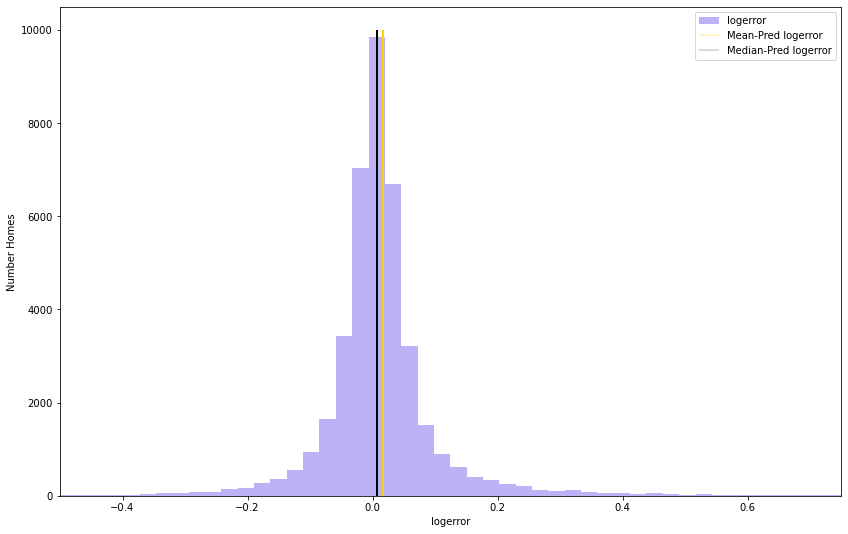

In [77]:
# plot to visualize actual vs predicted. 

plt.figure(figsize=(14, 9))
plt.hist(y_train.logerror, color='mediumslateblue', bins=300, alpha=.5, label="logerror")
plt.vlines(y_train.logerror_baseline_mean, 0, 10000, color='gold', alpha=.3, label="Mean-Pred logerror")
plt.vlines(y_train.logerror_baseline_median, 0, 10000, color='black', alpha=.2, label="Median-Pred logerror")
plt.xlim(-0.5, 0.75)
plt.xlabel("logerror")
plt.ylabel("Number Homes")
plt.legend()
plt.show()

***I will move forward with the median as it is performing better.***

In [78]:
# RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_baseline_median) ** (0.5)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_baseline_median) ** (0.5)

print(f"""
      BASELINE:
      RMSE using Median
      Train/In-Sample: {round(rmse_train, 6)}
      Validate/Out-of-Sample: {round(rmse_validate, 6)}
        """)


      BASELINE:
      RMSE using Median
      Train/In-Sample: 0.165961
      Validate/Out-of-Sample: 0.163941
        


### • Train / Validate
#### Modeling: LinearRegression (OLS)

In [79]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(0.5)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: {round(rmse_train_lm, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.165961
              Validate/Out-of-Sample: 0.163941

    RMSE for OLS using LinearRegression
    
    Training/In-Sample: 0.165209
    Validation/Out-of-Sample: 0.163243



#### LassoLars

In [80]:
# create the model object
# I will leave α as the defaulted 1 for now
# since DF has a small amt of features.
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(0.5)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}

    RMSE for LassoLars
    
    Training/In-Sample: {round(rmse_train_lars, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lars, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.165961
              Validate/Out-of-Sample: 0.163941
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.165209
                Validation/Out-of-Sample: 0.163243

    RMSE for LassoLars
    
    Training/In-Sample: 0.165662
    Validation/Out-of-Sample: 0.163619



#### PolynomialFeatures

In [81]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [82]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(0.5)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 6)}

                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: {round(rmse_train_lm2, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lm2, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.165961
              Validate/Out-of-Sample: 0.163941
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.165209
                Validation/Out-of-Sample: 0.163243

                RMSE for LassoLars
                
                Training/In-Sample: 0.165662
                Validation/Out-of-Sample: 0.163619

                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: 0.164157
    Validation/Out-of-Sample: 0.166042



#### Cubic function

In [83]:
# make the polynomial features to get a new set of features
pf3 = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf3.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf3.transform(X_validate_scaled)
X_test_degree3 = pf3.transform(X_test_scaled)

In [84]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.logerror)

# predict train
y_train['logerror_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train_lm3 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm3)**(0.5)

# predict validate
y_validate['logerror_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate_lm3 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 6)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 6)}

                RMSE for Polynomial Regressor
                degrees=2
        
                Training/In-Sample: {round(rmse_train_lm2, 6)}
                Validation/Out-of-Sample: {round(rmse_validate_lm2, 6)}
                
    RMSE for Polynomial Regressor
    degrees=3
    
    Training/In-Sample: {round(rmse_train_lm3, 6)}
    Validation/Out-of-Sample: {round(rmse_validate_lm3, 6)}              
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.165961
              Validate/Out-of-Sample: 0.163941
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.165209
                Validation/Out-of-Sample: 0.163243

                RMSE for LassoLars
                
                Training/In-Sample: 0.165662
                Validation/Out-of-Sample: 0.163619

                RMSE for Polynomial Regressor
                degrees=2
        
                Training/In-Sample: 0.164157
                Validation/Out-of-Sample: 0.166042
                
    RMSE for Polynomial Regressor
    degrees=3
    
    Training/In-Sample: 0.157857
    Validation/Out-of-Sample: 0.244456              



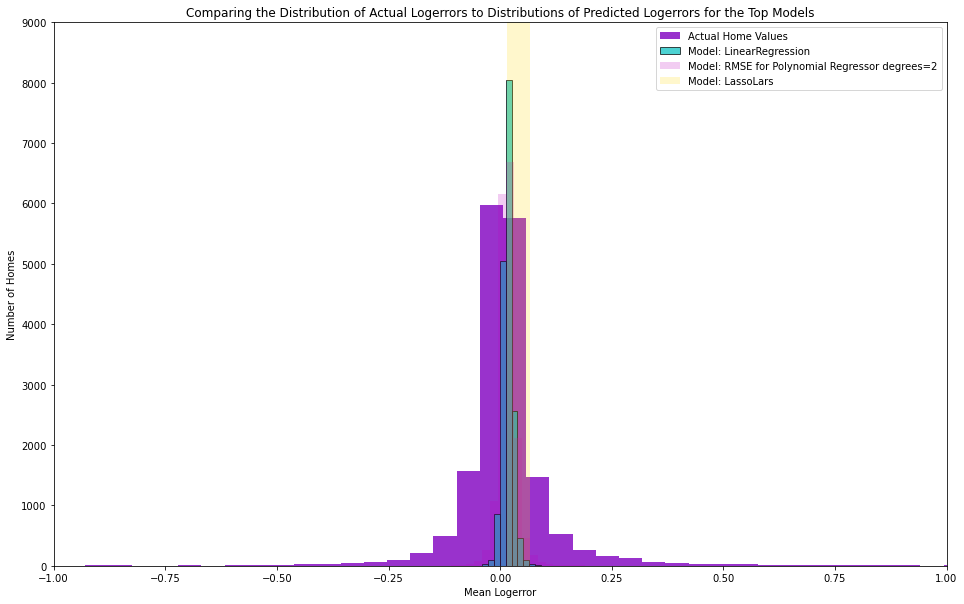

In [99]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.logerror, color='darkorchid', alpha=1, bins=100, label="Actual Home Values")
plt.hist(y_validate.logerror_pred_lm, color='c', alpha=.7, bins=25, label="Model: LinearRegression", ec='black')
#plt.hist(y_validate.logerror_pred_lm3, color='chartreuse', alpha=.2, bins=200, label="Model: RMSE for Polynomial Regressor degrees=3")
plt.hist(y_validate.logerror_pred_lm2, color='m', alpha=.2, bins=200, label="Model: RMSE for Polynomial Regressor degrees=2")
plt.hist(y_validate.logerror_pred_lars, color='gold', alpha=.2, bins=20, label="Model: LassoLars")

plt.xlim(-1, 1)
plt.ylim(0, 9000)
plt.xlabel("Mean Logerror")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Logerrors to Distributions of Predicted Logerrors for the Top Models")
plt.legend()
plt.show()

 [Jump to Table of Contents](#toc)

___
# <a name="test"></a>• Test

In [100]:
y_test = pd.DataFrame(y_test)

#predict on test
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm)**(0.5)

print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 6)}
              Validate/Out-of-Sample: {round(rmse_validate, 6)}
              
              
    RMSE for OLS using LinearRegression
    
    Test/Out-of-Sample Performance: {round(rmse_test, 6)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.165961
              Validate/Out-of-Sample: 0.163941
              
              
    RMSE for OLS using LinearRegression
    
    Test/Out-of-Sample Performance: 0.160463



 [Jump to the top of Repo](#top)

<a id='bottom'></a>